# Sales forecasting system (Regression Problem)

## Time series prediction in Python

In [ ]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import joblib

**STEP 1: PROBLEM STATEMENT & DATA COLLECTION**

***1.1 PROBLEM STATEMENT***

**Goal-** to develop a sales forecasting system to estimate the sales growth rate for the upcoming months. This information will help determine the necessary storage space required for a new warehouse as the company prepares to expand its operations.

#### This project will be developed in order to answer the following questions:
* Which is the tensor of the time serie?
* Which is the trend?
* Is it stationary?
* Is there variability or noise?

***1.2 DATA COLLECTION***

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [3]:
df.to_csv("../data/raw/sales.csv", index=False)

In [4]:
# Obtaining Dataset dimensions:
print("Dataset dimensions:")
print(df.shape)

Dataset dimensions:
(366, 2)


In [5]:
# Obtaining Dataset informations:
print("Dataset informations:")
print(df.info())

Dataset informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [6]:
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


**1.3 DATA TRANSFORMATION**

In [7]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
print(df.head())


                                sales
date                                 
2022-09-03 17:10:08.079328  55.292157
2022-09-04 17:10:08.079328  53.803211
2022-09-05 17:10:08.079328  58.141693
2022-09-06 17:10:08.079328  64.530899
2022-09-07 17:10:08.079328  66.013633


In [8]:
ts = df['sales']
ts.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

**1.4 TIME SERIES VISUALIZATION**

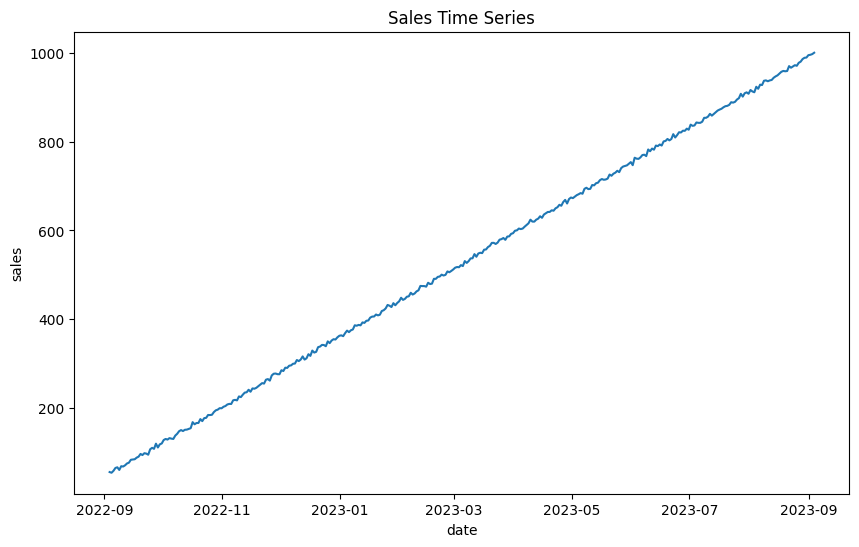

In [9]:
fig, axis = plt.subplots(figsize = (10, 6))
sns.lineplot(data=ts)
plt.title("Sales Time Series")
plt.show()


**STEP 2: BUILDING AND ANALYZING THE TIME SERIES**

***Which is the tensor of the time serie?***

In [10]:
freq_ = pd.infer_freq(ts.index)
print("Inferred frequency:", freq_)


Inferred frequency: D


#### Statement:
* the data has a daily granularity (D = daily)

***QUESTION 2: Which is the trend? (trend)***

#### 2.1 Decomposition of the series

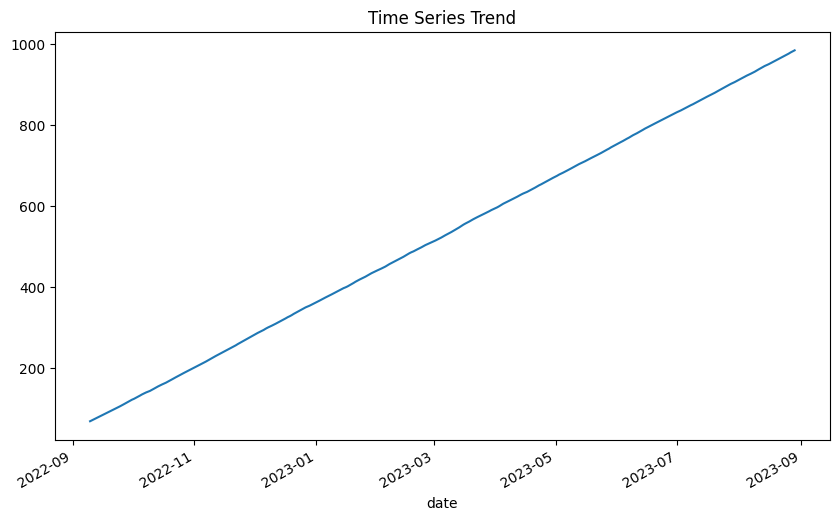

In [11]:
decomposition = seasonal_decompose(ts, period=12)
decomposition.trend.plot(figsize=(10, 6), title="Time Series Trend")
plt.show()

#### 2.2 Trend analysis

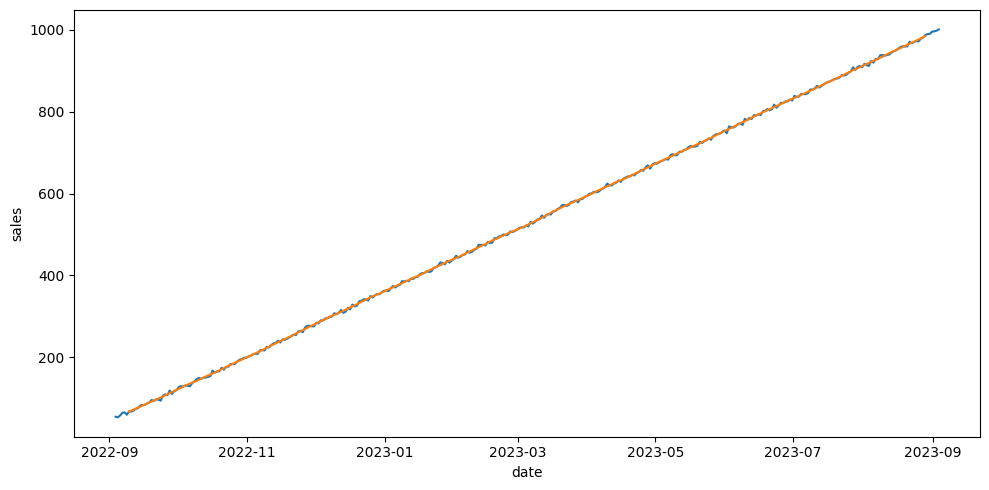

In [12]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

#### Statement: 
* this confirms a clear positive trend over the years.

***QUESTION 3: Is it stationary? (seasonality)***

In [13]:
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Dickey-Fuller test results:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

#### Statement:
* p-value is greater than 0.05, which means that null hypothesis will be rejected, and I will take this series as non-stationary.

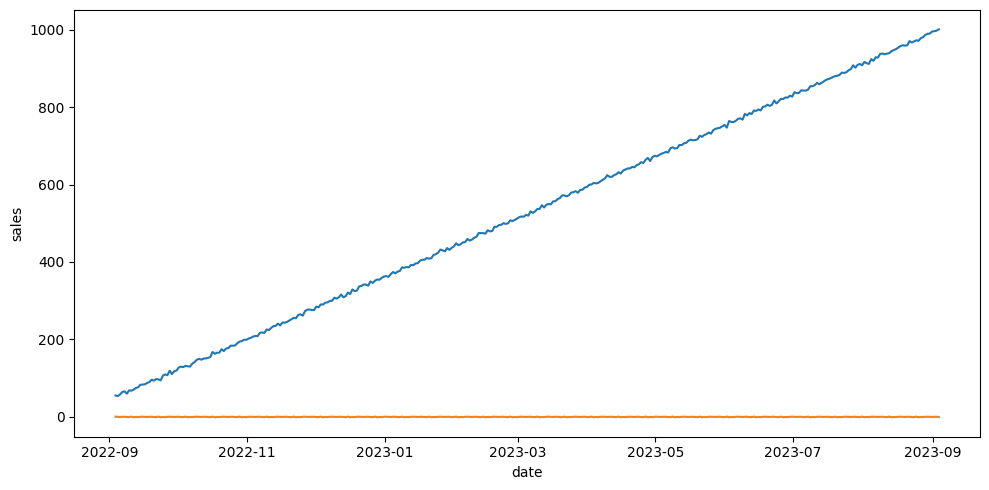

In [14]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

#### Statement:
* This graph confirms that the time series is not stationary, since it presents temporal dependencies, such as trends and seasonality, which need to be addressed before training a model such as ARIMA.

***QUESTION 4: Is there variability or noise? (variability)***

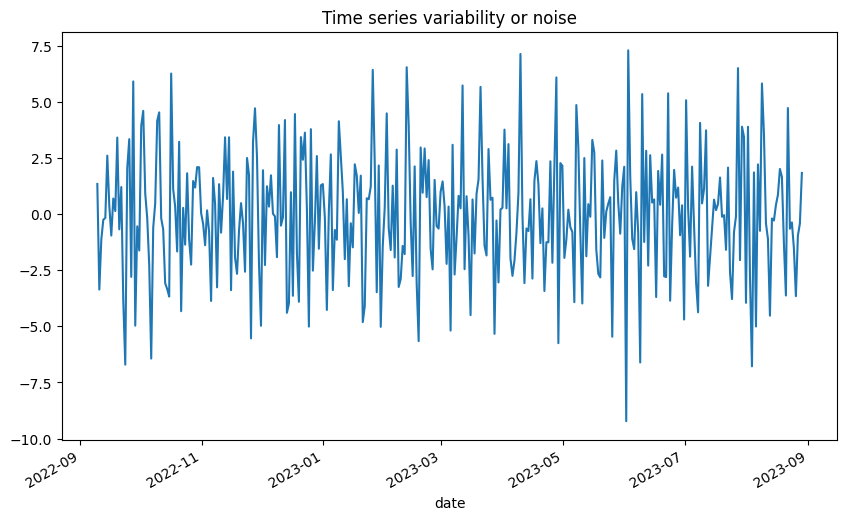

In [15]:
decomposition.resid.plot(figsize=(10, 6), title="Time series variability or noise")
plt.show()

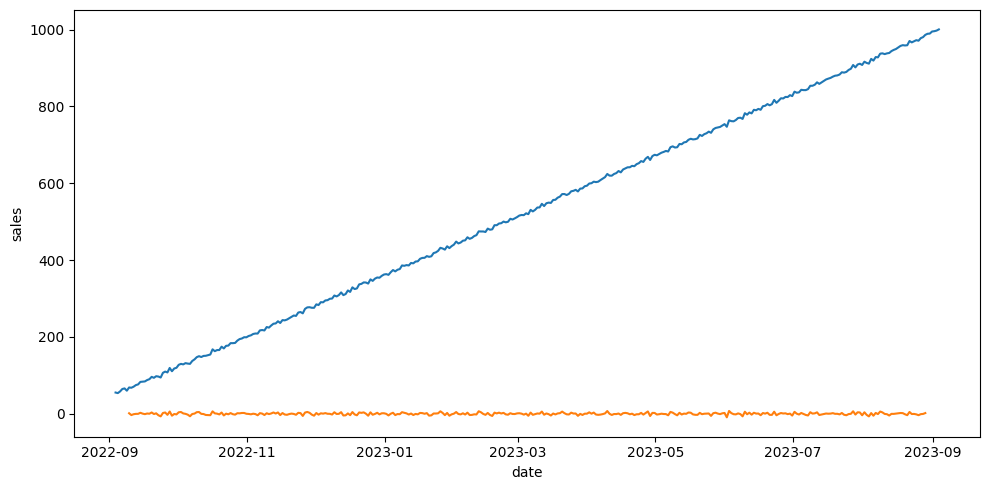

In [16]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

#### Statement:
* This partially confirms the observed behavior, as the residual variability appears to be more pronounced at both the beginning and the end of the studied period.

**AUTOCORRELATION ANALYSIS**

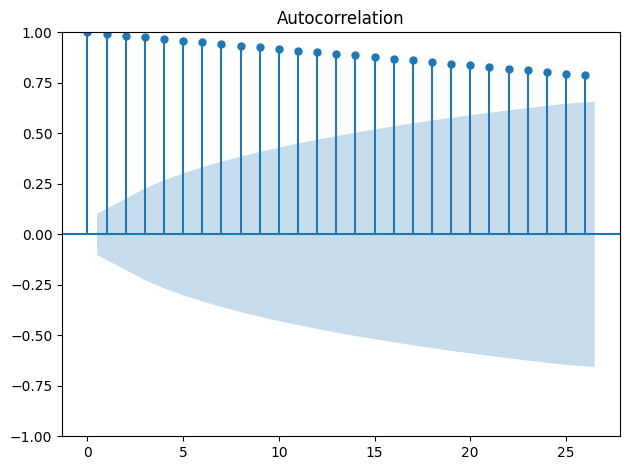

In [17]:
plot_acf(ts)

plt.tight_layout()

plt.show()

#### Statement: 
* there is a significant temporal dependence in the data.

**STEP 3: MODEL TRAINING with an ARIMA model**

In [18]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)


Dickey-Fuller test results:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

#### Statements: 
* p-values significantly lower than 0.05 - the series is stationary.
* At this point, time-dependent patterns (such as trends) have been removed, and the series is ready to be used in training an ARIMA model.

In [19]:
from pmdarima import auto_arima

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1847.118, Time=1.14 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1972.854, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1845.127, Time=0.55 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1843.049, Time=0.34 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=0.84 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1843.587, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1841.533, Time=0.27 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1843.436, Time=0.97 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=0.70 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1839.553, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[12] inte

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Wed, 27 Nov 2024   AIC                           1839.553
Time:                        19:11:05   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#
train = ts[:int(0.8 * len(df))]
test = ts[int(0.8 * len(df)):]

In [32]:
#
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  292
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -886.858
Date:                Wed, 27 Nov 2024   AIC                           1781.715
Time:                        19:24:23   BIC                           1796.422
Sample:                    09-03-2022   HQIC                          1787.606
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        428.7537   3222.230      0.133      0.894   -5886.701    6744.209
ar.L1          1.0000      0.001    883.989      0.000       0.998       1.002
ma.L1         -0.0767      0.080     -0.952      0.3

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


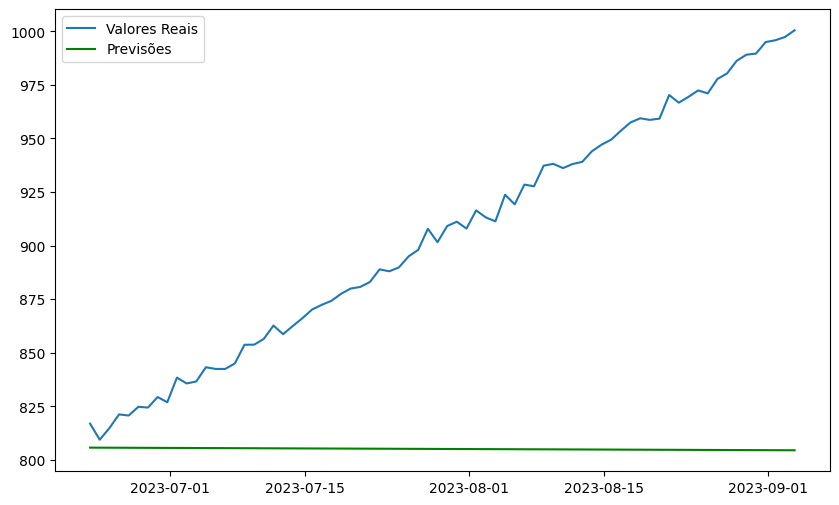

In [33]:
forecast = arima_result.forecast(steps=len(test))
plt.figure(figsize=(10, 6))
plt.plot(test, label='Valores Reais')
plt.plot(forecast, label='Previsões', color='green')
plt.legend()
plt.show()


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(test, forecast, squared=False)
mae = mean_absolute_error(test, forecast)
print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 114.11166069791584
MAE: 99.50369815899681


/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
forecast = model.predict(12)
forecast

2023-09-04 17:10:08.079328    1.675366
2023-09-05 17:10:08.079328    2.673520
2023-09-06 17:10:08.079328    2.591621
2023-09-07 17:10:08.079328    2.598341
2023-09-08 17:10:08.079328    2.597789
2023-09-09 17:10:08.079328    2.597834
2023-09-10 17:10:08.079328    2.597831
2023-09-11 17:10:08.079328    2.597831
2023-09-12 17:10:08.079328    2.597831
2023-09-13 17:10:08.079328    2.597831
2023-09-14 17:10:08.079328    2.597831
2023-09-15 17:10:08.079328    2.597831
Freq: D, dtype: float64

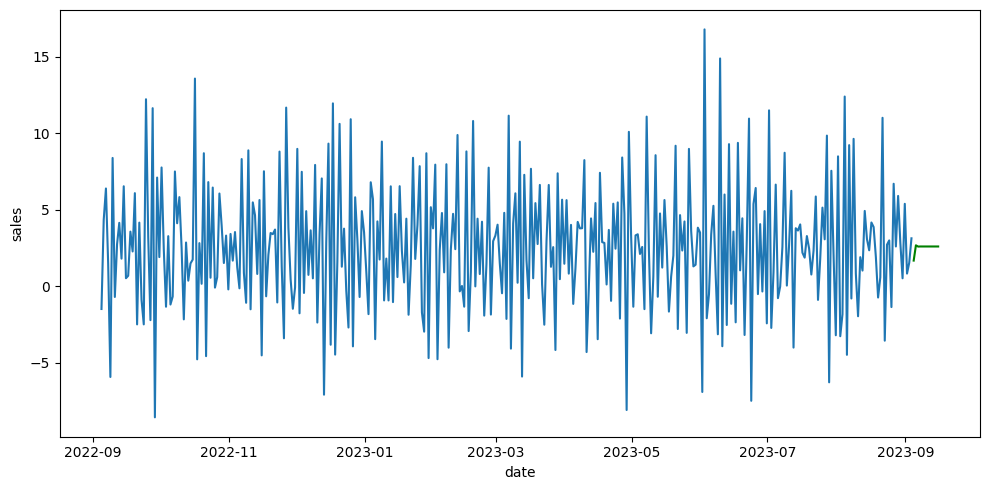

In [36]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

In [38]:
joblib.dump(arima_result, 'arima_model.pkl')

['arima_model.pkl']

In [ ]:
#loaded_model = joblib.load('arima_model.pkl')